In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model
from sklearn import metrics


import warnings # для игнорирования предупреждений
#Игнорируем предупреждения
warnings.filterwarnings('ignore')


# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

In [3]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


In [4]:
print(diabetes_data.shape)

(757, 8)


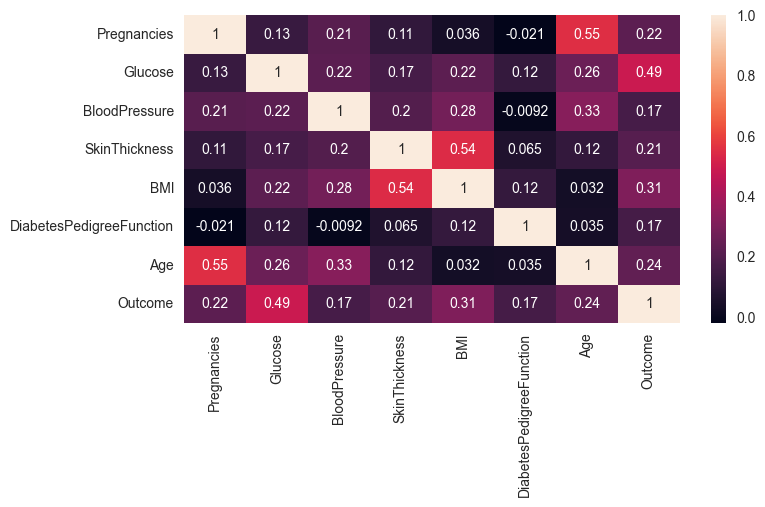

In [5]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(diabetes_data.corr(), annot=True);

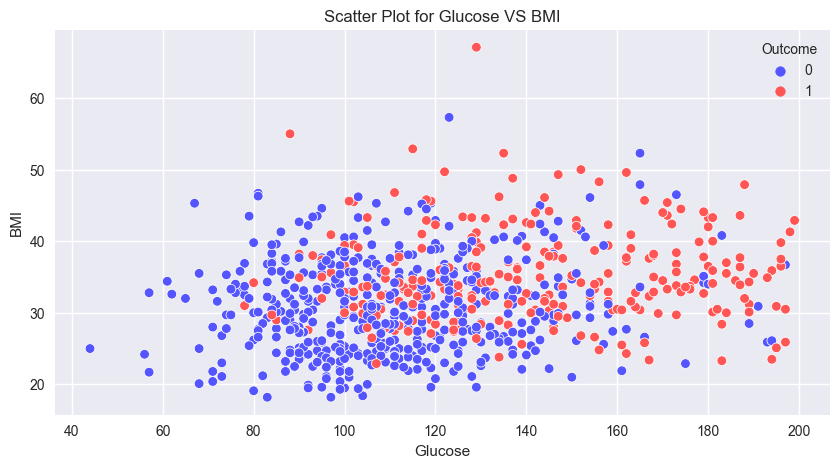

In [6]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);

#Задаём название графику
ax.set_title('Scatter Plot for Glucose VS BMI');

In [7]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

In [8]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минимизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-8.24898965]
w1, w2: [[0.03779275 0.0875742 ]]


In [9]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод predict_proba() возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметьте, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

Если мы хотим предсказать не вероятности, а сам класс (1 или 0), нам пригодится метод predict(). По умолчанию метод predict() относит объект к классу 1, если вероятность принадлежности к классу 1 > 0.5, и к классу 0, если эта вероятность < 0.5.

In [10]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


In [11]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

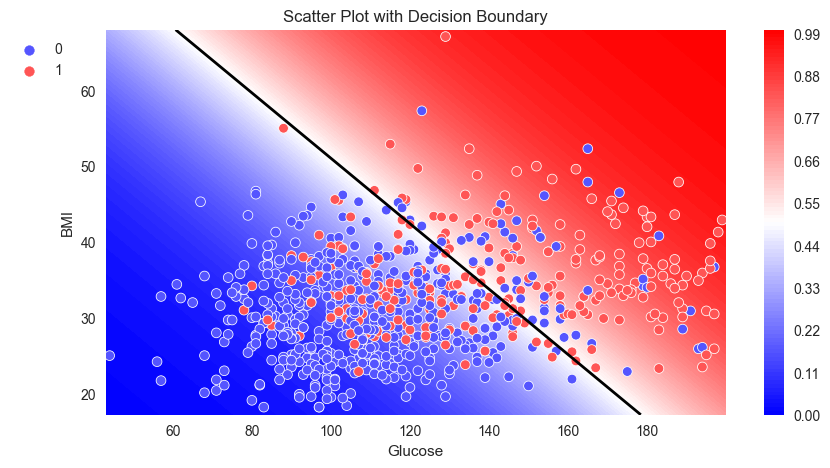

In [12]:
plot_probabilities_2d(X, y, log_reg_2d)

In [13]:
X_all = diabetes_data.drop('Outcome', axis=1)
y_all = diabetes_data['Outcome']

In [14]:
#Создаём объект класса LogisticRegression
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg_full.fit(X_all, y_all)
#Делаем предсказание класса
y_pred_all = log_reg_full.predict(X_all)

In [15]:
#Создадим временную таблицу X
X_temp = X_all.copy()
#Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred_all
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


In [16]:
df = pd.read_csv('data/task_data.csv')

In [17]:
df

,SNo,X_1,X_2,y
0,0,-0.869144,0.389310,0.0
1,1,-0.993467,-0.610591,0.0
2,2,-0.834064,0.239236,0.0
3,3,-0.136471,0.632003,1.0
4,4,0.403887,0.310784,1.0
...,...,...,...,...
95,95,0.531635,-0.479185,1.0
96,96,-0.650192,0.655303,1.0
97,97,0.985299,0.118333,1.0
98,98,-0.275289,0.005730,1.0


In [18]:
df = df.drop('SNo', axis=1)

In [19]:
X_t = df.drop('y', axis=1)
y_t = df['y']

In [20]:
#Создаём объект класса LogisticRegression
log_reg_t = linear_model.LogisticRegression(random_state=42, solver='sag')
#Обучаем модель, минимизируя logloss
log_reg_t.fit(X_t, y_t)

LogisticRegression(random_state=42, solver='sag')

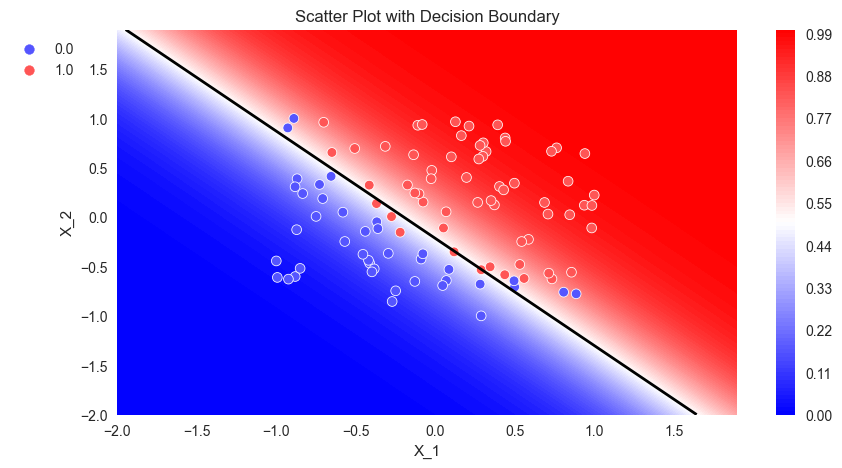

In [21]:
plot_probabilities_2d(X_t, y_t, log_reg_t)

МЕТРИКИ

``` python 

Функции, которые нам понадобятся:  
confusion_matrix() — расчёт матрицы ошибок,  
accuracy_score() — расчёт accuracy,  
precision_score() — расчёт precision,  
recall_score() — расчёт recall,  
f1_score() — расчёт -меры.

```

In [22]:
#Делаем предсказание моделью, обученной на двух признаках 
y_pred1 = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']])
#Делаем предсказание моделью, обученной на всех признаках 
y_pred2 = log_reg_full.predict(diabetes_data.drop('Outcome', axis=1))

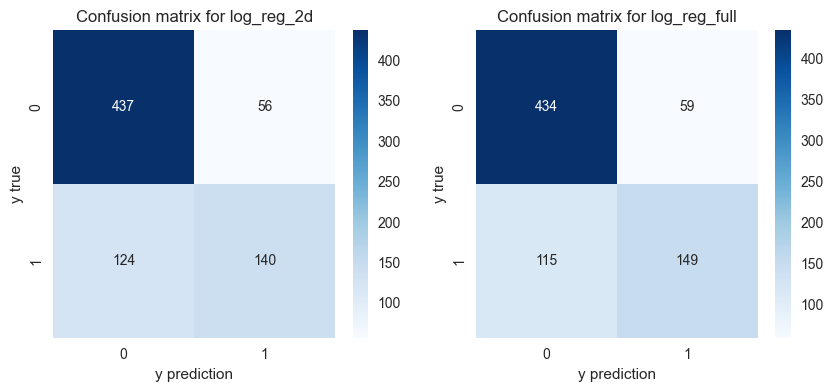

In [23]:
#Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')
#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true');

In [24]:
#Модель log_reg_2d:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


In [25]:
#Модель log_reg_full:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.56
F1 score: 0.63


In [26]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.56      0.63       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



In [27]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes_data.drop('Outcome', axis=1))[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

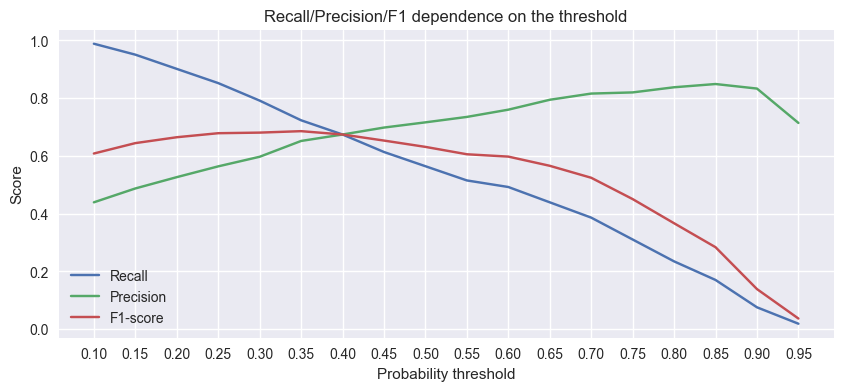

In [28]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

**Что мы видим на графике?**

С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как диабетиков только тех пациентов, в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение -меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка threshold=0.4, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства -меры.

Однако максимум -меры достигается в другой точке — threshold=0.35. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что для нас все таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при threshold=0.4.

In [29]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.4
#Пациентов, для которых вероятность наличия диабета > 0.4, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       493
           1       0.67      0.67      0.67       264

    accuracy                           0.77       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.77      0.77      0.77       757



In [30]:
y_true = [0, 0, 1, 1, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1]

In [31]:
round(metrics.precision_score(y_true, y_pred), 2)

0.75

In [32]:
round(metrics.recall_score(y_true, y_pred), 2)

0.6

In [33]:
round(metrics.f1_score(y_true, y_pred), 2)

0.67

МУЛЬТИКЛАССОВАЯ КЛАССИФИКАЦИЯ

In [34]:
penguins_data = sns.load_dataset('penguins')
penguins_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [35]:
penguins_data.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [36]:
penguins_data = penguins_data.dropna()

In [37]:
X = penguins_data.drop('species', axis=1)
y = penguins_data['species']
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [38]:
X_dummies = pd.get_dummies(X)
X_dummies.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,0,0,1,0,1


In [39]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', #мультиклассовая классификация
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)
 
#Обучаем модель 
log_reg.fit(X_dummies, y)
#Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_dummies), 2)
#Делаем предсказание класса
y_pred = log_reg.predict(X_dummies)

In [40]:
#Создаём DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Adelie', 'Chinstrap', 'Gentoo']
)
#Создаём DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)
#Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
#Выбираем пять случайных строк
y_df.sample(5, random_state=2)

,Adelie,Chinstrap,Gentoo,Predicted Class
277,0.00,0.00,1.0,Gentoo
223,0.00,0.00,1.0,Gentoo
7,0.79,0.21,0.0,Adelie
160,0.00,1.00,0.0,Chinstrap
65,1.00,0.00,0.0,Adelie


In [41]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       146
   Chinstrap       1.00      1.00      1.00        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



ДЕРЕВЬЯ РЕШЕНИЙ

In [42]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


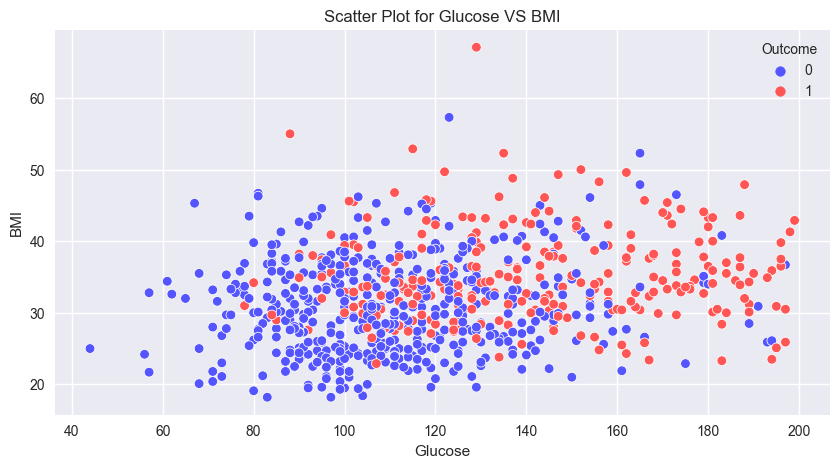

In [43]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('Scatter Plot for Glucose VS BMI');

In [44]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

In [45]:
from sklearn import tree #модели деревьев решения

In [46]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

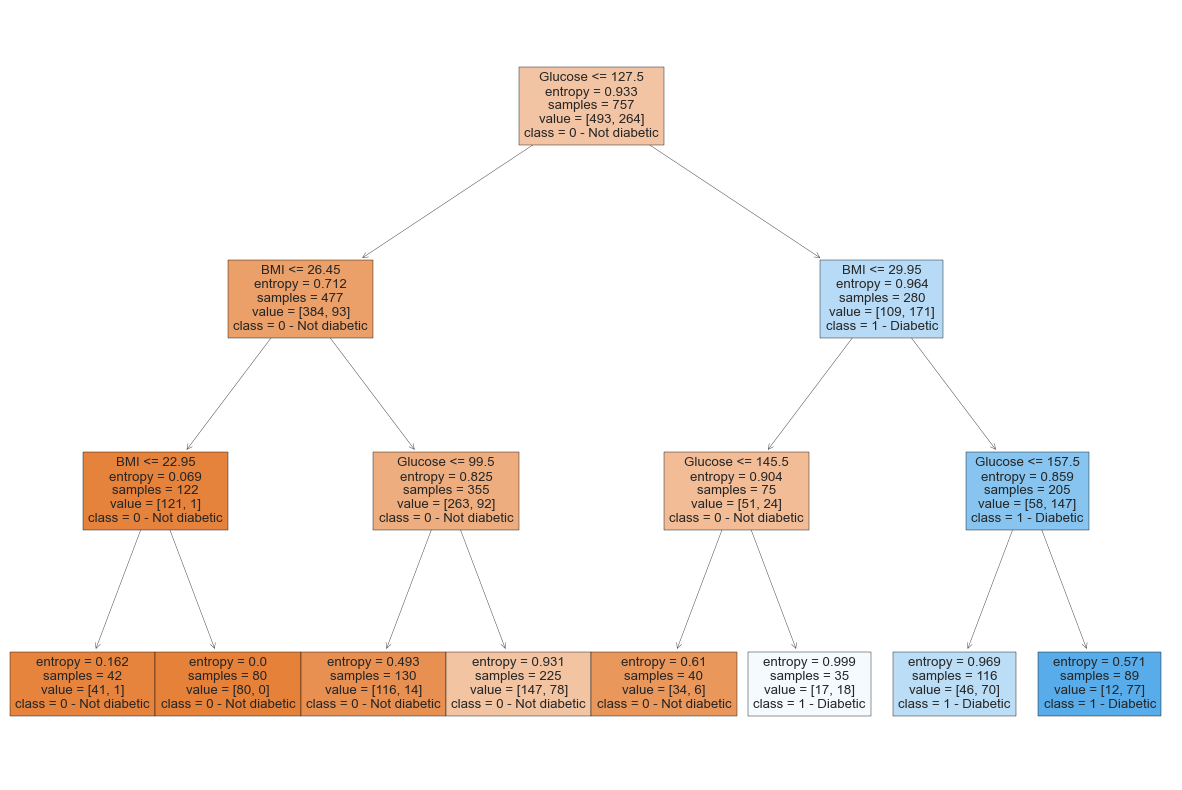

In [47]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [48]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


In [49]:
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted probabilities: [[0.135 0.865]]


In [50]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от 40 до 200, BMI — от 10 до 80
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(40, 200, 0.1),
        np.arange(10, 80, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(data=X, x='Glucose', y='BMI', hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

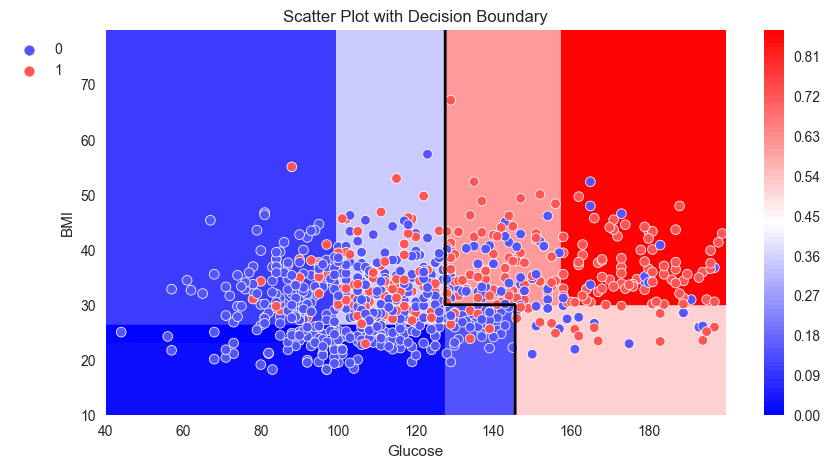

In [51]:
plot_probabilities_2d(X, y, dt_clf_2d)

In [52]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_2d.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



In [53]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его длины
dt_clf_bad.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [54]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_bad.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



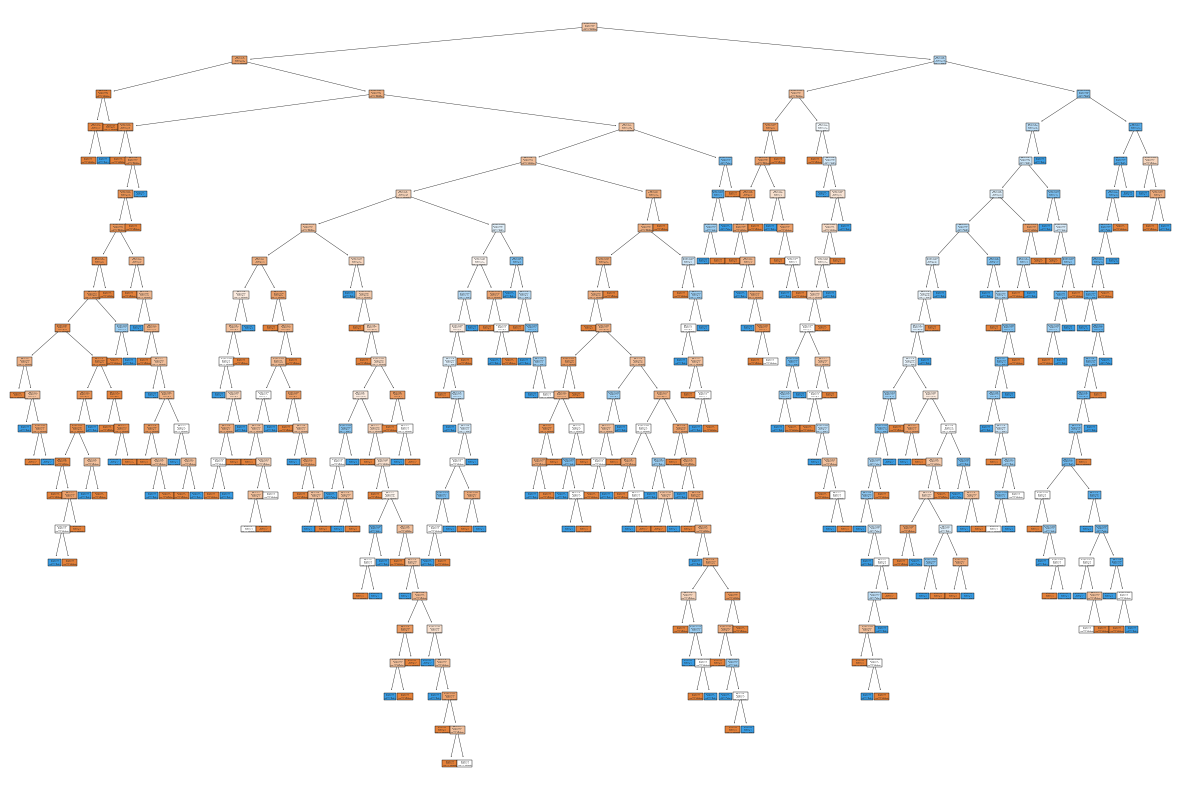

In [55]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф 
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [57]:
# Посмотрим получившуюся глубину дерева
dt_clf_bad.get_depth()

22

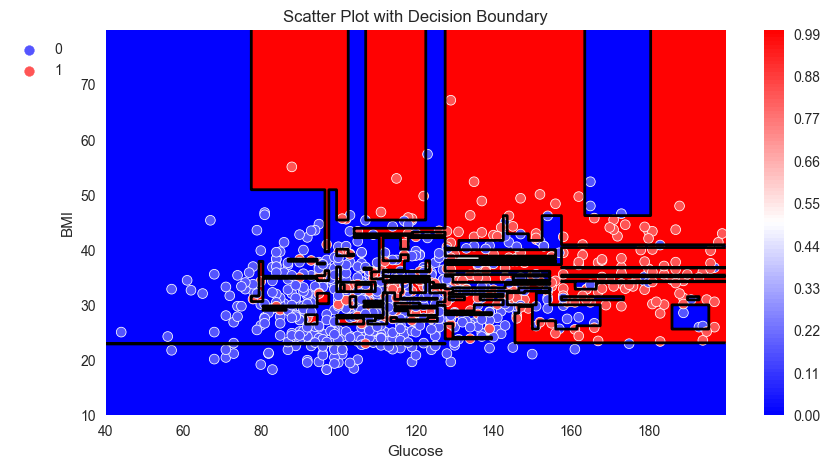

In [58]:
plot_probabilities_2d(X, y, dt_clf_bad)

In [59]:
#Создаём матрицу признаков X и столбец с ответами y
X_all = diabetes_data.drop('Outcome', axis=1)
y_all = diabetes_data['Outcome']

In [60]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X_all, y_all)
 
#Делаем предсказание класса
y_all_pred = dt_clf_full.predict(X_all)
#Выводим отчёт о метриках
print(metrics.classification_report(y_all, y_all_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



In [61]:
# определим важность признаков
print(dt_clf_full.feature_importances_)

[0.02675774 0.36675873 0.03368236 0.04553664 0.24588118 0.14137465
 0.14000868]


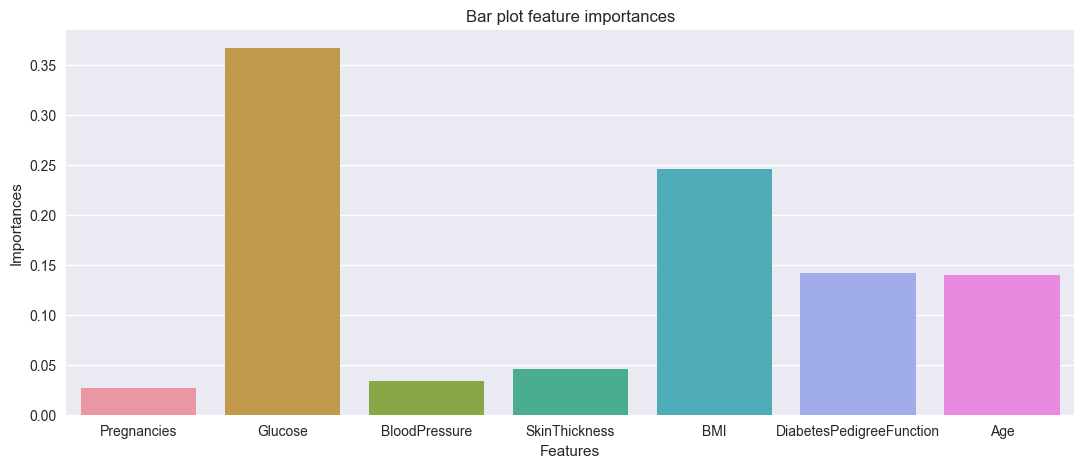

In [62]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_all.columns #признаки
feature_importances = dt_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [64]:
dt_clf_g = tree.DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=6)
dt_clf_g.fit(X_all, y_all)
y_all_pred_g = dt_clf_g.predict(X_all)

print('F1-score: {}'.format(metrics.f1_score(y_all, y_all_pred_g)))

F1-score: 0.7820773930753563


Введение в ансамбли: бэггинг. Случайный лес

In [65]:
from sklearn import ensemble

In [66]:
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=3, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X, y)
 
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       493
           1       0.73      0.57      0.64       264

    accuracy                           0.78       757
   macro avg       0.76      0.73      0.74       757
weighted avg       0.77      0.78      0.77       757



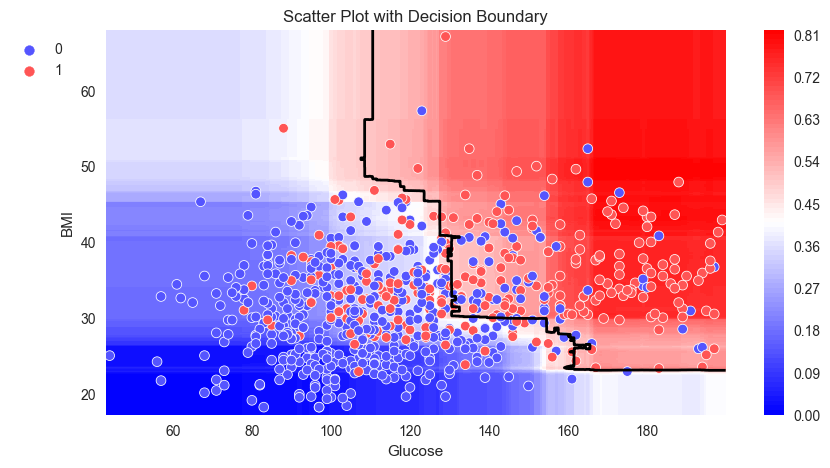

In [67]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость (линию, где вероятность равна 0.5)
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
plot_probabilities_2d(X, y, rf_clf_2d)

In [68]:
#Создаём объект класса RandomForestClassifier
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=300, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X_all, y_all)
 
#Делаем предсказание класса
y_all_pred = rf_clf_full.predict(X_all)
#Выводим отчёт о метриках
print(metrics.classification_report(y_all, y_all_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       493
           1       0.85      0.77      0.80       264

    accuracy                           0.87       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.87      0.87      0.87       757



In [69]:
rf_clf_full.predict_proba(X_all)

array([[0.7186633 , 0.2813367 ],
       [0.85222366, 0.14777634],
       [0.88358167, 0.11641833],
       ...,
       [0.28908312, 0.71091688],
       [0.44280536, 0.55719464],
       [0.94476689, 0.05523311]])

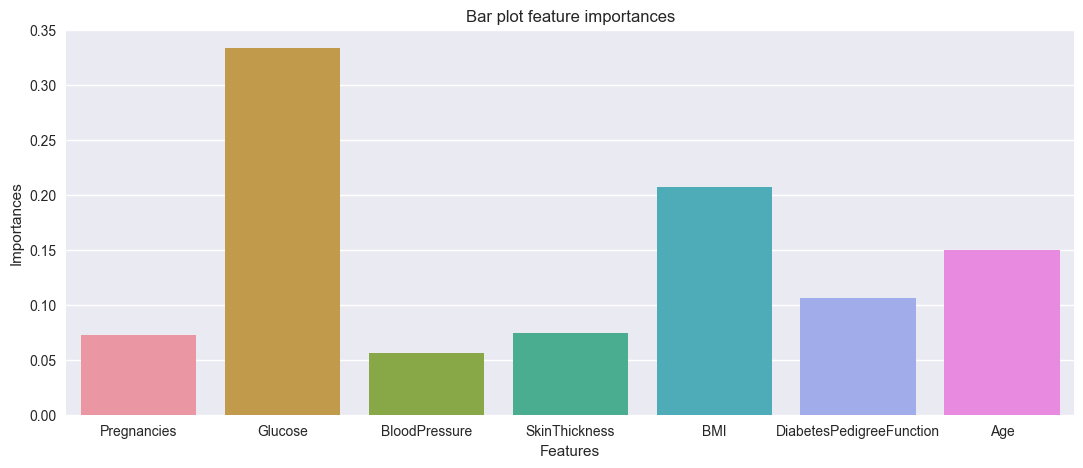

In [71]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_all.columns #признаки
feature_importances = rf_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [98]:
wine_data = pd.read_csv('data/winequality-red.csv', sep=';')

In [99]:
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [100]:
wine_data['quality'] = wine_data['quality'].apply(lambda x: 1 if x>=6 else 0)
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

In [95]:
from sklearn.model_selection import train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
#Создаём объект класса RandomForestClassifier
rf_clf_v = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10, #минимальное число объектов в листе
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_v.fit(X_train, y_train)
 
#Делаем предсказание класса
y_train_pred = rf_clf_v.predict(X_train)
y_test_pred = rf_clf_v.predict(X_test)
#Выводим подсчет метриках
print('Acc train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Acc test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Acc train: 0.85
Acc test: 0.75
